In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas as pd
import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

colors = ['orange', 'teal', 'purple',"cyan","red"] 
plt.rcParams.update({
    #"text.usetex": True,
    #"font.family": "Helvetica", 
    "font.size":14})

import scipy as sp

#tools that may be useful to analyse the data

#function to draw the posterior distribution
def pairplot_from_array(parameter, column_names=None, hue=None, save_path=None,bins=20):
    if not isinstance(parameter, np.ndarray):
        raise ValueError("parameter is not a numpy array")

    if column_names is None:
        column_names = [f"Columns_{i}" for i in range(parameter.shape[1])]

    df = pd.DataFrame(parameter, columns=column_names)

    if hue is not None and hue not in column_names:
        raise ValueError(f"The columns '{hue}' ")
    
    plot_kws = {"bins": bins}

    
    if len(parameter)<=10000:
        sns.pairplot(df, hue=hue, corner=True, kind="kde", plot_kws=plot_kws)
    else:
        sns.pairplot(df, hue=hue, corner=True, kind="hist",diag_kind="kde", plot_kws=plot_kws)
        
    plt.show()
    
def plot_convergence(parameter, column_names=None):
    if not isinstance(parameter, np.ndarray):
        raise ValueError("parameter is not a numpy array")

    if column_names is None:
        column_names = [f"Columns_{i}" for i in range(parameter.shape[1])]
    for i in range(parameter.shape[1]):
        fig, ax = plt.subplots(1,1,figsize=(8, 5))
        ax.plot(parameter[:,i])
        ax.set_xlabel("step")
        ax.set_ylabel(column_names[i])
        ax.set_xscale("log")
    plt.show()

    
def plot_convergence_method(parameter, column_names=None, method_names=None):
    if not isinstance(parameter, np.ndarray):
        raise ValueError("parameter is not a numpy array")

    if column_names is None:
        column_names = [f"Columns_{i}" for i in range(parameter.shape[2])]
    if method_names is None:
        method_names = [f"method_{i}" for i in range(parameter.shape[0])]
    for i in range(parameter.shape[2]):
        fig, ax = plt.subplots(1,1,figsize=(8, 5))
        for j in range(parameter.shape[0]):
            ax.plot(parameter[j,:,i],label=method_names[j],alpha=0.5,color=colors[j+1])
        ax.set_xlabel("step")
        ax.legend()
        ax.set_ylabel(column_names[i])
        ax.set_xscale("log")
    plt.show()

def autocorrelation(data):
    n = len(data)
    
    mean = np.mean(data)
    centered_data = data - mean
    
    variance = np.dot(centered_data, centered_data)
    
    result = np.correlate(centered_data, centered_data, mode='full') / variance
    result = result[n-1:]
    return result    

def plot_autocorrelation(parameter, column_names=None):
    if not isinstance(parameter, np.ndarray):
        raise ValueError("parameter is not a numpy array")

    if column_names is None:
        column_names = [f"Columns_{i}" for i in range(parameter.shape[1])]
    for i in range(parameter.shape[1]):
        fig, ax = plt.subplots(1,1,figsize=(8, 5))
        ax.plot(autocorrelation(parameter[:,i]))
        ax.set_xlabel("lag")
        ax.set_ylabel("autocorrelation("+column_names[i]+")")
        ax.set_xscale("log")
    plt.show()

    
def plot_autocorrelation_method(parameter, column_names=None, method_names=None):
    if not isinstance(parameter, np.ndarray):
        raise ValueError("parameter is not a numpy array")

    if column_names is None:
        column_names = [f"Columns_{i}" for i in range(parameter.shape[2])]
    if method_names is None:
        method_names = [f"method_{i}" for i in range(parameter.shape[0])]
    for i in range(parameter.shape[2]):
        fig, ax = plt.subplots(1,1,figsize=(8, 5))
        for j in range(parameter.shape[0]):
            ax.plot(autocorrelation(parameter[j,:,i]),
                    label=method_names[j],alpha=0.5,color=colors[j+1])
        ax.set_xlabel("lag")
        ax.legend()
        ax.set_ylabel("autocorrelation("+column_names[i]+")")
        ax.set_xscale("log")
    plt.show()

def plot_hist(hist,xbin, title = None):
    fig, ax = plt.subplots(1,1,figsize=(8, 5))
    ax.hist((xbin[:-1]+xbin[1:])/2.,bins=xbin,weights=hist)
    ax.set_xlabel("x_bin")
    if title != None:
        ax.set_title(title)
    plt.show()
    
def plot_acceptance_rate(parameters, title = None, number_of_batch = 10):
    n = len(parameters)
    batch_size = int(n/number_of_batch)
    print(batch_size)
    acceptation = []
    for i in range(number_of_batch):
        unique_values, occurrences = np.unique(parameters[i*batch_size:(i+1)*batch_size,:], 
                                               axis=0, return_counts=True)
        acceptation.append(float(len(unique_values))/float(batch_size))
    fig, ax = plt.subplots(1,1,figsize=(8, 5))
    ax.plot(acceptation,color=colors[2])
    ax.set_xlabel("batch")
    ax.set_ylabel("acceptance ratio")
    if title != None:
        ax.set_title(title)
    plt.show()
    
###############################################################################
# function to compute the likelihood between a model and histogrammed data.

# compute poisson likelihood between a model array and histogrammed data
def compute_poisson_loglikelihood(model, histo_data):
    logf = np.log(sp.special.factorial(histo_data))
    logf[np.isinf(logf)==True] = ((histo_data[np.isinf(logf)==True])*
                                  np.log(histo_data[np.isinf(logf)==True])-
                                  histo_data[np.isinf(logf)==True]+1.)
    LL = np.sum(-model+histo_data*np.log(model)-logf)
    return LL
    
# compute normal likelihood between a model array and histogrammed data
def compute_normal_loglikelihood(model, histo_data, sigma):
    LL = np.sum(-(model-histo_data)**2/(2.*sigma**2))
    return LL

###################################################
#exponential decay model

#sample generator according to exponential decay (exp(-lambda*t))
#input: 
#  - n : number of sample
#  - lambda : decay rate
def run_sample_exp_decay(n,lamb):
    return np.random.exponential(1./lamb, size=n)

#compute the expted value in each bin for a exponantial decay of n event :
#input:
#  - n : number of sample
#  - lambda : decay rate
#  - xbin : the bin edge of the histogram
def compute_expectation_exp_decay(n,lamb,xbin):
    model = -n*(np.exp(-lamb*xbin[1:])-
                np.exp(-lamb*xbin[:-1]))
    return model

###################################################
#background model

#sample generator according to uniform background
#input: 
#  - rate : rate in time unit
#  - tmin, tmax : interval for the event generation
def run_sample_uniform_bck(rate, tmin, tmax):
    dt = tmax-tmin
    nevt = np.random.poisson(rate*dt,1)
    return np.random.uniform(tmin,tmax,nevt)
    
#compute the expected value for uniform background
#input: 
#  - rate : rate in unit
#  - xbin : the bin edge of the histogram
def compute_expectation_uniform_bck(rate,xbin):
    model = np.zeros_like(xbin[:-1])+rate*(xbin[1]-xbin[0])
    return model

###################################################
#Normal model

#sample generator according to normal distribution
#input: 
#  - A : number of event
#  - mu, 
#  - sigma
def run_sample_normal(A, mu, sigma):
    return np.random.normal(mu,sigma,A)
    
#compute the expected value for normal distribution
#input: 
#  - A, mu, sigma : rate in time unit
#  - xbin : the bin edge of the histogram
def compute_expectation_normal(A,mu,sigma,xbin):
    model = sp.stats.norm.cdf(xbin[1:], loc=mu, scale=sigma) - sp.stats.norm.cdf(xbin[:-1], loc=mu, scale=sigma)
    return model*A

In [14]:
#my helper functions

def plot_histogram_components(data,n_bins=None):
    var_names = ["$z_e$","$z_\\nu$","$\\phi$ (rad)"]
    data_count = data.shape[0]
    if (n_bins == None):
        n_bins = int(np.sqrt(data_count))
    for i in range(data.shape[1]):
        fig, ax = plt.subplots(figsize=(6,6))
        ax.set_xlabel(var_names[i])
        ax.set_ylabel("Counts")
        ax.hist(data[:,i],bins=n_bins)
        plt.plot

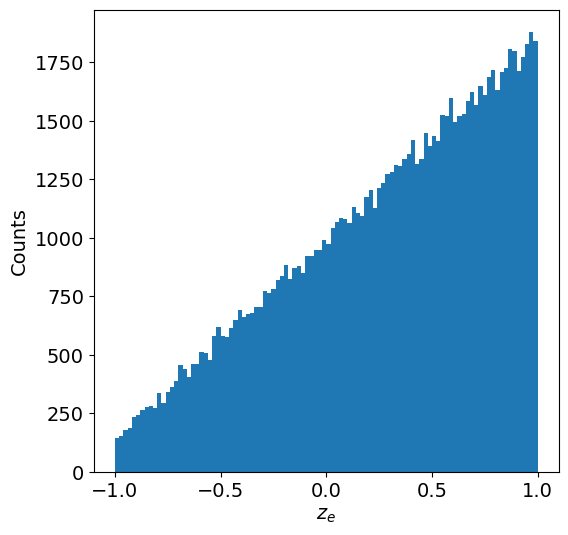

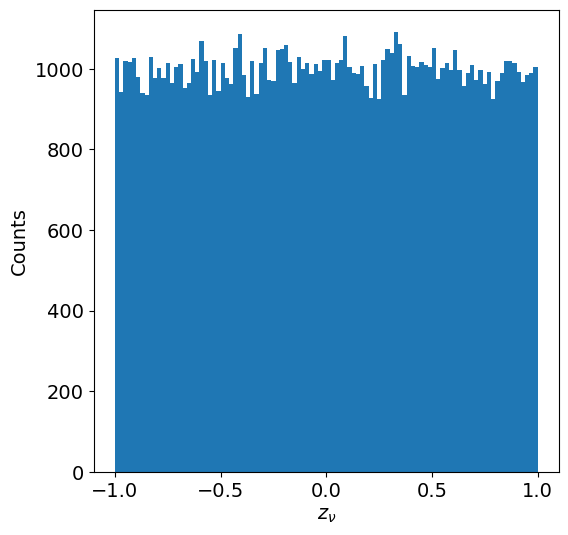

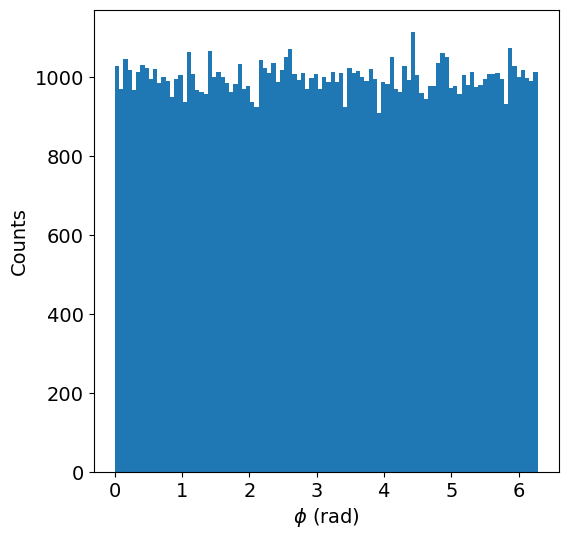

In [15]:
filename = "build/sample_A.txt"

data = np.loadtxt(filename)

plot_histogram_components(data,100)